<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 4 : Visualisation de vecteurs de mots

## Résumé
Le but de ce laboratoire est de visualiser des vecteurs de mots grâce à des méthodes de réduction de dimensionnalité.  La visualisation permettra de deviner plus facilement le "mot du jour" dans le jeu en ligne [Cémantix](https://cemantix.certitudes.org/).

## 1. Prise en main de word2vec

Le modèle Word2vec contient des _embeddings_ des mots qui sont appris automatiquement à partir de textes.  Chaque mot est donc représenté par un vecteur dans un espace avec plusieurs centaines de dimensions (p.ex. 300 ou 500).  Dans cet espace, les mots de sens ou d'usage proches ont des vecteurs proches (les _embeddings_ capturent la similarité entre mots).  Mais la dimensionnalité de l'espace fait qu'il est difficile de visualiser les vecteurs de mots.

La librairie [Gensim](https://radimrehurek.com/gensim/index.html) permet de charger un modèle Word2vec existant (avec la fonction `load_word2vec_format(...)`) et de manipuler les vecteurs de mots (instances de la classe `KeyedVectors`).  On peut notamment utiliser la fonction `similarity(w1, w2)` qui retourne le cosinus des vecteurs correspondant aux mots `w1` et `w2`, à condition que ceux-ci soient connus du modèle.  On peut aussi utiliser la fonction `most_similar([w])` qui retourne les mots voisins d'un ou plusieurs mots.  La [documentation de KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html) fournit des exemples utiles.

Veuillez télécharger l'_un des deux_ modèles word2vec suivants, déjà entraînés, mis à disposition par [J.-Ph. Fauconnier](https://fauconnier.github.io/#data):
- [frWac_no_postag_no_phrase_500_cbow_cut100.bin](https://embeddings.net/embeddings/frWac_no_postag_no_phrase_500_cbow_cut100.bin) - plus petit (229 Mo), mais pas identique au modèle utilisé pour Cémantix ;
- [frWac_no_postag_phrase_500_cbow_cut10.bin](https://embeddings.net/embeddings/frWac_no_postag_phrase_500_cbow_cut10.bin) - bien plus grand (2 Go) donc assez gourmand en mémoire, mais qui est exactement celui utilisé pour Cémantix.
Veuillez placer le modèle choisi dans le dossier `gensim-data` de votre dossier utilisateur.

In [1]:
# Téléchargement, si nécessaire.
# import wget
# url = 'https://embeddings.net/embeddings/frWac_no_postag_no_phrase_500_cbow_cut100.bin'
# wget.download(url, path_to_model)

In [2]:
from gensim.models import KeyedVectors

In [3]:
path_to_model = "/home/hugo/gensim-data/frWac_no_postag_phrase_500_cbow_cut10.bin" # à adapter

In [4]:
model = KeyedVectors.load_word2vec_format(path_to_model, binary=True, unicode_errors="ignore")

a. Choisissez deux mots de sens proches `w1` et `w2`, et un autre plus différent noté `w3`. Affichez la similarité selon word2vec (cosinus) entre chaque paire de mots.  Ces valeurs correspondent-elles à vos intuitions ?

In [5]:
w1 = "salut"
w2 = "bonjour"
w3 = "ananas"

print(model.similarity(w1, w2))
print(model.similarity(w1, w3))

0.60424685
0.06367243


**Réponse**: Oui, les résultats sont plutôt cohérents.

b. Affichez les 10 mots les plus proches de `w1` selon word2vec avec pour chacun sa similarité avec `w1`. 

In [6]:
model.similar_by_word(w1, 10)

[('hello', 0.6205763816833496),
 ('a+', 0.6185073256492615),
 ('bonjour', 0.6042468547821045),
 ('bonsoir', 0.575570821762085),
 ('bye', 0.575313150882721),
 ('hiteule_#_posté', 0.5720421671867371),
 ('@+', 0.5704692006111145),
 ('slt', 0.5658148527145386),
 ('voiler', 0.5592634081840515),
 ('merci', 0.5561856031417847)]

c. Quels sont les 15 premiers coefficients du vecteur (_embedding_) du mot `w1` ? Quelle est la dimension de ce vecteur ?  Quelle est la taille du vocabulaire connu du modèle ?  Vous pouvez simplement écrire les commandes répondant à ces questions.

In [7]:
w1_vec = model.get_vector(w1)
print(f"15 premiers coefficients: {w1_vec[:15]}")
print(f"dimension: {w1_vec.shape}")
print(F"taille du vocabulaire du modèle: {model.vectors.shape[0]}")

15 premiers coefficients: [ 0.15651798 -0.254017    0.63510066 -0.32978034  0.62693226  1.1254677
  0.498993    0.18130495  0.48041025  2.0941763  -0.8354767   3.032552
  1.0572803  -1.143155   -1.6907729 ]
dimension: (500,)
taille du vocabulaire du modèle: 1081995


d. Veuillez écrire une fonction appelée `neighbors` selon les spécifications suivantes.  Cette fonction servira plus loin pour l'affichage.
* input : modèle, liste de mots, nombre de voisins (`topn`) ;
* output : liste de mots voisins de chacun des mots de l'input, représentés par un dictionnaire expliqué ci-après ;
* fonctionnement : pour _chacun_ des mots donnés en input, la fonction teste si le mot est dans le vocabulaire du modèle word2vec (sinon elle ne le considère pas), puis demande au modèle la liste des `topn` mots voisins ; pour chacun de ces mots, la fonction construit un `dict` à 4 champs : 
  - mot voisin
  - similarité
  - mot de départ
  - code de couleur associé au mot de départ : 1, 2, etc.

**Exemple** : si on appelle la fonction avec \['école'\], le début du résultat sera :
```
[{'neighbor': 'scolaire',
  'similarity': 0.7114928364753723,
  'ref_word': 'école',
  'color_code': 1}, ...
```

In [8]:
def neighbors(model, word_list, topn = 5):
    cnt = 0
    ret = list()
    for word in word_list:
        if model.has_index_for(word):
            cnt += 1
            for (neighbor, similarity) in model.similar_by_word(word, topn):
                ret.append({
                    "neighbor": neighbor,
                    "similarity": similarity,
                    "ref_word": word,
                    "color_code": cnt
                })
    return ret

In [9]:
print(neighbors(model, ['chat', 'étudier'], 5))

[{'neighbor': 'minou', 'similarity': 0.6334686875343323, 'ref_word': 'chat', 'color_code': 1}, {'neighbor': 'matou', 'similarity': 0.626587450504303, 'ref_word': 'chat', 'color_code': 1}, {'neighbor': 'petit_chatte', 'similarity': 0.6141418218612671, 'ref_word': 'chat', 'color_code': 1}, {'neighbor': 'chatte', 'similarity': 0.5922409892082214, 'ref_word': 'chat', 'color_code': 1}, {'neighbor': 'miauler', 'similarity': 0.5909050107002258, 'ref_word': 'chat', 'color_code': 1}, {'neighbor': 'étude', 'similarity': 0.6593688726425171, 'ref_word': 'étudier', 'color_code': 2}, {'neighbor': 'analyser', 'similarity': 0.6340749263763428, 'ref_word': 'étudier', 'color_code': 2}, {'neighbor': 'approfondir', 'similarity': 0.5609511733055115, 'ref_word': 'étudier', 'color_code': 2}, {'neighbor': 'différent', 'similarity': 0.5528215765953064, 'ref_word': 'étudier', 'color_code': 2}, {'neighbor': 'examiner', 'similarity': 0.5415564179420471, 'ref_word': 'étudier', 'color_code': 2}]


## 2. Affichage simple des voisins d'un mot

Pour commencer, veuillez étudier et exécuter le code fourni en exemple : `Labo4_plotly.ipynb`.  Cela vous montrera comment utiliser l'affichage 2D/3D avec `plotly.js`, et vous permettra de traiter les questions suivantes.

Veuillez écrire et exécuter une fonction qui effectue les opérations suivantes, étant donné un mot en entrée :
* obtenir les vecteurs word2vec du mot et de ses `topn` plus proches voisins ;
* transformer ces vecteurs en 2D par l'ACP ;
* afficher en 2D chaque points correspondant à un mot, avec comme étiquette le mot lui-même.

**Notes:** cette fonction sert de version préliminaire à une fonction plus générique demandée ci-dessous.  Il n'est pas demandé de distinguer le mot entré des mots voisins, dans l'affichage (même type de points).  Il n'est pas nécessaire pour l'instant d'utiliser la fonction `neighbors`.

In [10]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

In [11]:
def display_PCA_2D_neighbors(model, word, topn = 5):
    neighbours = [word for word, _ in model.similar_by_word(word, topn=topn)]
    words = [word] + neighbours

    points = np.array([model.get_vector(w) for w in words])
    points = PCA(n_components=2).fit_transform(points)

    go.Figure(go.Scatter(x=points[:, 0],
                         y=points[:, 1],
                         name=f"{word} et {topn} voisins",
                         text=words,
                         mode="text")).show()

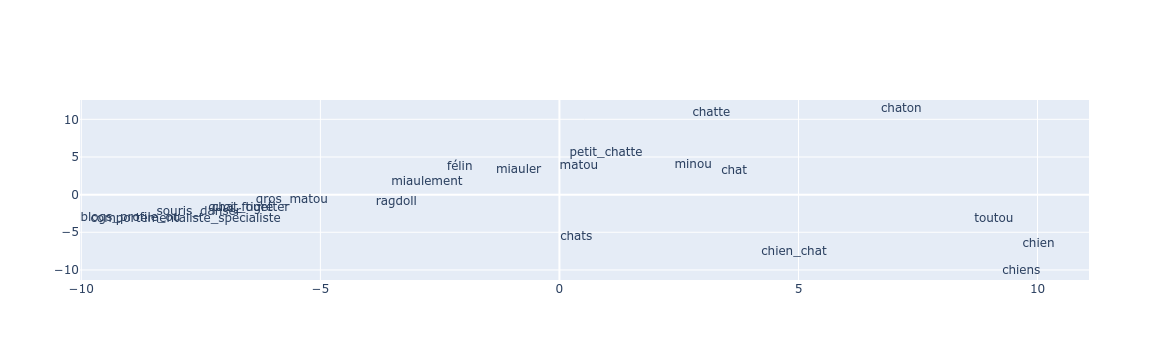

In [23]:
# Afficher le mot 'chat' et ses 20 plus proches voisins
# projetés en deux dimensions avec PCA (test de la fonction).
display_PCA_2D_neighbors(model, 'chat', 20)

## 3. Affichage configurable des voisins de plusieurs mots

Le but maintenant est d'écrire une fonction `display_dimred_neighbors` qui affiche sur un seul graphique les mots voisins de chaque mot d'une liste de mots donnés.  Vous utiliserez ici la fonction auxiliaire `neighbors` définie plus haut  Les paramètres suivants seront passés à la fonction `display_dimred_neighbors` :

* `model` - le nom du modèle word2vec
* `word_list` - liste de mots dont on veut afficher les voisins (s'ils existent dans `model`)
* `n_components` - dimensionnalité de l'affichage, 2 ou 3
* `topn` - nombre de voisins à afficher pour chaque mot 
* `method` - **méthode de réduction de dimensionnalité : pca, mds, isomap, tsne, ou umap**
* `n_neighbors`- nombre de voisins considérés par la méthode (applicable à isomap, umap, et tsne (appelé alors `perplexity`)).

Trois tests sont demandés à la question 4, mais vous pouvez en exécuter d'autres et les inclure ici.

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from umap import UMAP # Attention, installer le module nommé 'umap-learn' (avec conda install).

ModuleNotFoundError: No module named 'umap'

In [ ]:
def display_dimred_neighbors(model, word_list, n_components = 3, topn = 5, method = 'pca', n_neighbors = 5):


## 4. Application à l'étude des mots voisins dans word2vec

Veuillez choisir quatre mots (`word_list = [m1, m2, m3, m4]`) de façon à ce que m1 et m2 soient très proches par leur sens ou leur usage, m3 un peu plus éloigné, et m4 très éloigné.  L'objectif de cette question est d'étudier la distribution des mots voisins de ces quatre mots (entre 10 et 50) par une visualisation en 2D ou en 3D des vecteurs de mots.  

En expérimentant avec plusieurs configurations (méthode de réduction de dimensionnalité, valeur de `n_neighbors`, nombre de voisins `topn`), veuillez répondre aux questions suivantes, à l'aide d'un ou plusieurs graphiques par question :

**a.** si on utilise une méthode de réduction de dimensionnalité linéaire (PCA ou MDS métrique), les quatre groupes de mots sont-ils clairement séparés dans word2vec ?

**b.** si on utilise une méthode de réduction de dimensionnalité non-linéaire (Isomap, t-SNE ou UMAP), peut-on mieux mettre en évidence les quatre groupes de mots ?  Quels sont les meilleurs paramètres que vous avez trouvés permettant de bien identifier les quatre ensembles ?

**c.** inversement, trouvez-vous des paramètres qui aboutissent à cinq clusters ? ou à trois ?

In [ ]:
# Insérer ici la liste de mots.


In [ ]:
# Question 4a


In [ ]:
# Question 4b


In [ ]:
# Question 4c


## 5. Outil d'assistance pour le jeu Cémantix

Le jeu en ligne [Cémantix](https://cemantix.certitudes.org/) (aussi proposé sur le site [Dictaly](https://www.dictaly.com/semantiques/))  demande de deviner le *mot du jour* en l'approchant peu à peu par des mots candidats.  Pour chacun, le système indique pour sa similarité word2vec avec le *mot du jour*, ce qui permet de se rapprocher graduellement de la solution.  Expérimentez d'abord un court instant avec le jeu 😀.

L'objectif de cette question est de visualiser les voisinages de mots, pour vous aider à proposer des mots candidats et trouver plus vite la solution.  La procédure est la suivante :
* essayez trois mots au hasard dans Cémantix
* affichez 20-30 mots voisins de ces trois mots grâce à la fonction `display_dimred_neighbors`
* à l'aide des mots affichés, essayez des mots candidats dans Cémantix
* changez l'affichage en remplaçant les trois mots par de meilleurs mots
* continuez jusqu'à trouver le *mot du jour*

**Notes**
* si vous le souhaitez, vous pouvez utiliser le modèle word2vec identique à celui de Cémantix, qui est frWac_no_postag_phrase_500_cbow_cut10.bin fourni par [J.-Ph. Fauconnier](https://fauconnier.github.io/#data)
* ce modèle fait environ 2.3 Go et contient aussi des expressions de plusieurs mots (séparés par '_')
* vous pouvez choisir d'utiliser le petit ou le grand modèle, sachant qu'avec le premier, les suggestions sont moins pertinentes
* Cémantix ignore les expressions de plusieurs mots présentes dans le grand modèle -- vous pouvez choisir de le faire ou non.

In [ ]:
# candidate_words = ['homme', 'rouge', 'étudier']
candidate_words = ['rendement', 'rentabilité']
display_dimred_neighbors(model, candidate_words, n_components = 3, topn = 30, method = 'tsne')

Veuillez noter ici vos observations sur la procédure, et coller un extrait montrant votre meilleure performance au jeu.

**Fin du Labo.**  Veuillez nettoyer ce notebook en gardant seulement les résultats désirés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.